# Spec Repeatability

In [1]:
# Get files
# List all files in the directory
import glob
files = sorted(glob.glob("/Users/esteves/Downloads/spectrometer_local/repeatability/20250311T122109_scanavg_00001*"))
print(len(files))

9999


In [2]:
# compute the mean and std of the counts for each wavelength
import numpy as np
def readtxt(file):
    data = np.loadtxt(file, skiprows=1)
    return data[:, 0], data[:, 1]  # Return wavelengths and counts

wav = readtxt(files[0])[0]  # Assuming all files have the same wavelength array
data = np.array([readtxt(f)[1] for f in files])

In [3]:
def get_stats(x):
    mean_counts = np.median(x, axis=0)
    std_counts = np.std((x-mean_counts)/mean_counts, axis=0)
    return mean_counts, std_counts

mean_counts, std_counts = get_stats(data)
residuals = (data - mean_counts[np.newaxis,:])/mean_counts[np.newaxis,:]

print("Mean counts shape:", mean_counts.shape)
print("Std counts shape:", std_counts.shape)

print("Mean signal:", np.mean(mean_counts))
print("Std signal[%]:", 100*np.mean(std_counts))


Mean counts shape: (2048,)
Std counts shape: (2048,)
Mean signal: 6421.9453125
Std signal[%]: 0.43485057645881464


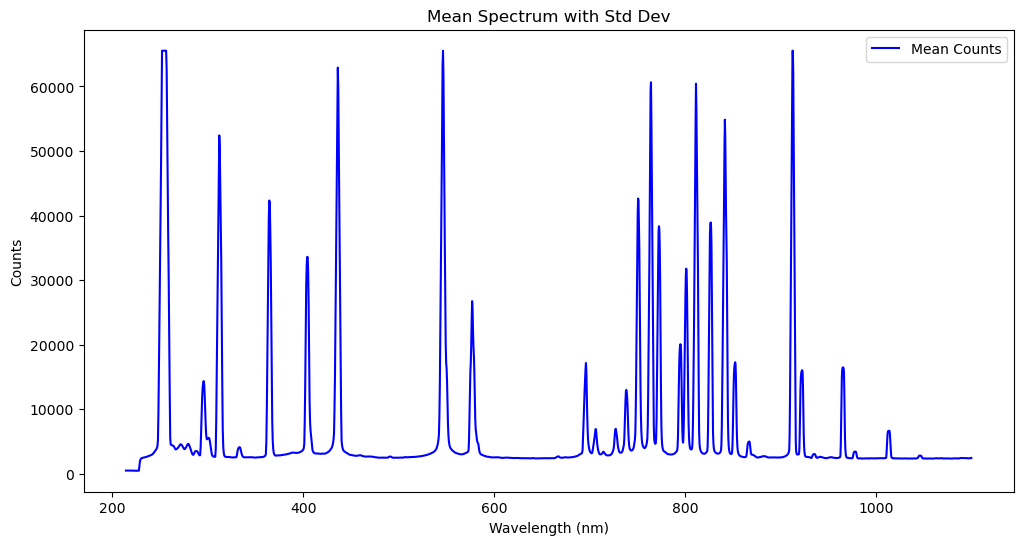

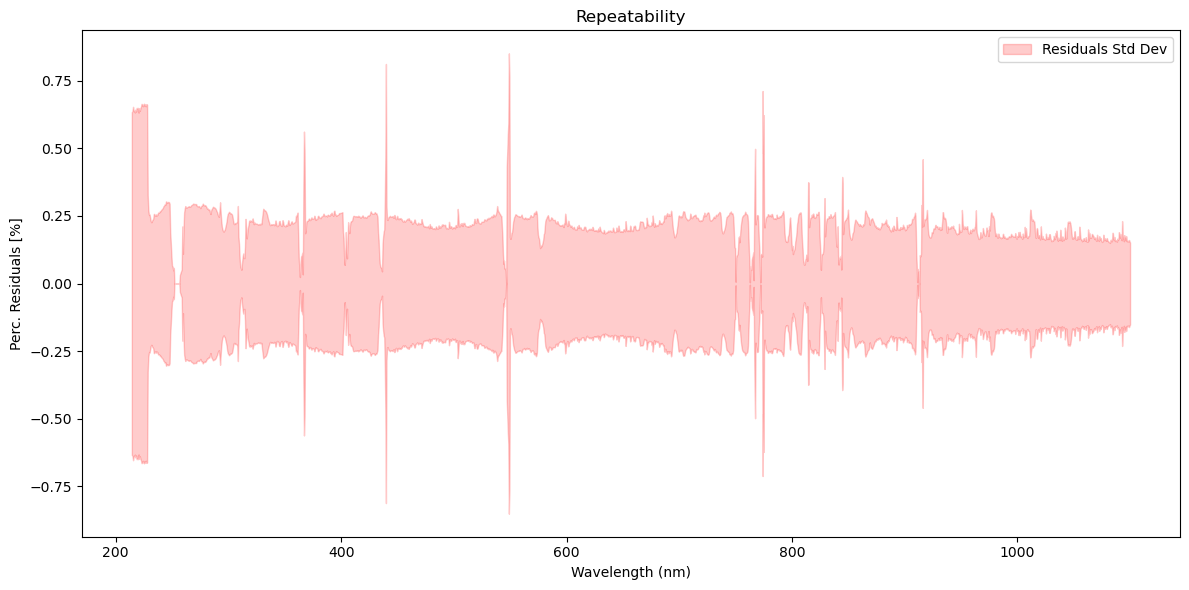

In [4]:
# plot the profiles
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(wav, mean_counts, label='Mean Counts', color='blue')
# plt.fill_between(wav, mean_counts - std_counts/2, mean_counts + std_counts/2, color='blue', alpha=0.2, label='Std Dev')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts')
plt.title('Mean Spectrum with Std Dev')
plt.legend()

# Plot Residuals
plt.figure(figsize=(12, 6))
plt.fill_between(wav, -100*std_counts/2, 100*std_counts/2, color='red', alpha=0.2, label='Residuals Std Dev')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Perc. Residuals [%]')
plt.title('Repeatability')
plt.legend()
plt.tight_layout()
plt.savefig('spec_repeatability_10000.png',dpi=120)

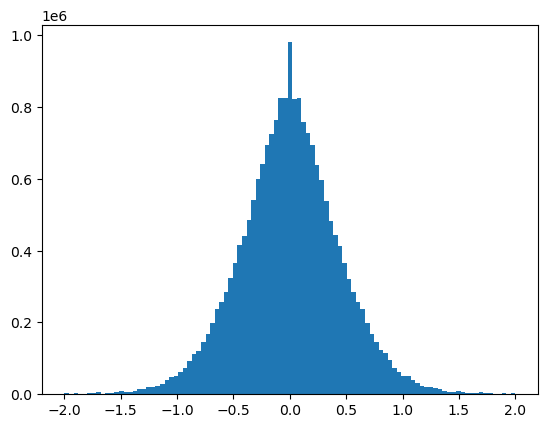

In [5]:
_ = plt.hist(100*residuals.flatten(),bins=np.linspace(-2,2,100))

## Check SNR

In [6]:
files2 = sorted(glob.glob("/Users/esteves/Downloads/spectrometer_local/repeatability/20250311T122109_scanavg_00010*"))
files3 = sorted(glob.glob("/Users/esteves/Downloads/spectrometer_local/repeatability/20250311T122109_scanavg_00100*"))
files4 = sorted(glob.glob("/Users/esteves/Downloads/spectrometer_local/repeatability/20250311T122109_scanavg_01000*"))

In [7]:
# wav = readtxt(files[0])[0]  # Assuming all files have the same wavelength array
data2 = np.array([readtxt(f)[1] for f in files2])
data3 = np.array([readtxt(f)[1] for f in files3])
data4 = np.array([readtxt(f)[1] for f in files4])

In [8]:
data2.shape

(1000, 2048)

In [9]:
data3.shape

(100, 2048)

In [10]:
data4.shape

(9, 2048)

In [11]:
base = np.median(data,axis=0)
np.mean(np.std(100*(data-base)/base,axis=1))

0.44686714520656257

In [12]:
nscans = [1, 10, 100, 1000]
precisions=[]
for d in [data, data2, data3, data4]:
    prec = np.mean(np.std(100*(d-base)/base,axis=1))
    precisions.append(prec)

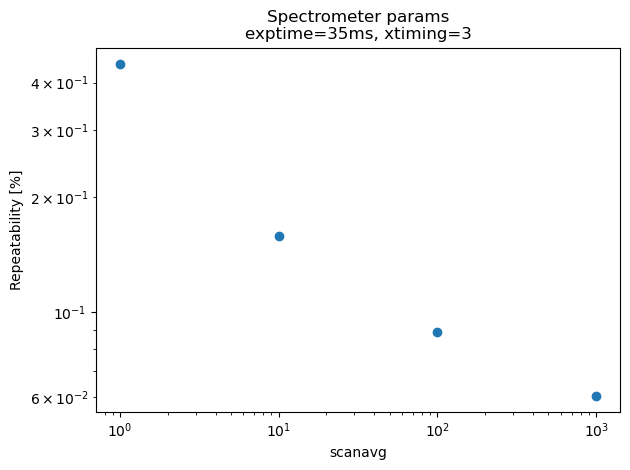

In [13]:
# plt.xscale('log')
plt.loglog()
plt.scatter(nscans, precisions)
plt.ylabel('Repeatability [%]')
plt.xlabel('scanavg')
plt.title('Spectrometer params\n'+'exptime=35ms, xtiming=3')
plt.tight_layout()
plt.savefig('spec_repeatability_scanavg.png',dpi=120)

# Line Strength vs Exptime

In [14]:
root = '/Users/esteves/Downloads/spectrometer_local/exptime'
timestamp = '20250311T153442'

exptimes = [2,3,5,6,9,12]
exptimes+= [12+5*(i+1) for i in range(10)]
exptimes+= [62+20*(i+1) for i in range(4)]
exptimes+= [142+50*(i+1) for i in range(4)]
exptimes+= [1000+500*i for i in range(4)]
exptimes+= [10000+5000*i for i in range(3)]
# exptimes

In [15]:
exptimes[18:]

[122, 142, 192, 242, 292, 342, 1000, 1500, 2000, 2500, 10000, 15000, 20000]

In [16]:
# import os
# timestamp2 = '20250311T122109'

# exptime = 342
# f1 = f"{root}/{timestamp2}_{exptime}ms.txt"
# f2 = f"{root}/{timestamp}_{exptime}ms.txt"
# os.rename(f1, f2)

In [17]:
# compute the mean and std of the counts for each wavelength
import numpy as np
def readtxt(file):
    data = np.loadtxt(file, skiprows=1)
    return data[:, 0], data[:, 1]  # Return counts

wav = readtxt(f"{root}/{timestamp}_2ms.txt")[0]  # Assuming all files have the same wavelength array
window = 5

In [18]:
from pandora.calibration.hg2_lamp import hg2_lines

def crop_line(wav, counts, line_wavelength, window):
    # Crop the data around the line
    mask = (wav >= line_wavelength - window) & (wav <= line_wavelength + window)
    return wav[mask], counts[mask]

line_strength = {}
line_positions = {}

# Loop over lines
for line_name, line_wavelength in hg2_lines.items():
    print(f"{line_name}: {line_wavelength}")
    # loop over the exptimes
    lineheights = []
    linepositions = []
    for exptime in exptimes:
        # load the spectrum
        data = readtxt(f"{root}/{timestamp}_{exptime}ms.txt")[1]
        # crop the data around the line
        # Assuming the wavelength range is around the line wavelength
        # For simplicity, let's assume a 10 nm window around the line
        cropped_wav, cropped_counts = crop_line(wav, data, line_wavelength, window)

        # get the peak position and the peak height
        peak_height = np.max(cropped_counts)
        peak_position = cropped_wav[np.argmax(cropped_counts)]
        #print(f"    Peak position: {peak_position:.4f} nm, Peak height: {peak_height:.0f}")
        lineheights.append(peak_height)
        linepositions.append(peak_position)
    line_strength[line_name] = lineheights
    line_positions[line_name] = linepositions
    # print the max/min counts for this line
    print(f"  {line_name}: Max counts: {max(lineheights):.2f}, Min counts: {min(lineheights):.2f}")
    # print the max/mean/min positions for this line
    print(f"  {line_name}: Max position: {max(linepositions):.2f} nm, Mean position: {np.mean(linepositions):.2f} nm, Min position: {min(linepositions):.2f} nm")

# Save the dictionaries as pandas dataframes
import pandas as pd
line_strength_df = pd.DataFrame(line_strength, index=exptimes)
line_positions_df = pd.DataFrame(line_positions, index=exptimes)

# append the two dataframes
result_df = pd.concat([line_strength_df, line_positions_df], axis=1, keys=['Strength', 'Position'])
result_df.to_csv(f"{root}/{timestamp}_line_strength_positions.csv")




Hg01: 253.652
  Hg01: Max counts: 65535.00, Min counts: 43821.00
  Hg01: Max position: 252.65 nm, Mean position: 251.28 nm, Min position: 248.89 nm
Hg02: 296.7284
  Hg02: Max counts: 65535.00, Min counts: 3728.00
  Hg02: Max position: 296.29 nm, Mean position: 295.26 nm, Min position: 292.06 nm
Hg03: 302.1506
  Hg03: Max counts: 65535.00, Min counts: 3140.00
  Hg03: Max position: 297.34 nm, Mean position: 297.34 nm, Min position: 297.34 nm
Hg04: 312.96
  Hg04: Max counts: 65535.00, Min counts: 8882.00
  Hg04: Max position: 312.59 nm, Mean position: 311.74 nm, Min position: 308.39 nm
Hg05: 334.1482
  Hg05: Max counts: 65535.00, Min counts: 2407.00
  Hg05: Max position: 333.99 nm, Mean position: 333.04 nm, Min position: 329.31 nm
Hg06: 365.235
  Hg06: Max counts: 65535.00, Min counts: 7447.00
  Hg06: Max position: 365.50 nm, Mean position: 364.17 nm, Min position: 360.36 nm
Hg07: 404.6565
  Hg07: Max counts: 65535.00, Min counts: 6226.00
  Hg07: Max position: 405.19 nm, Mean position: 40

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
result_df['Position']['Ar23'].plot()

In [ ]:
result_df['Strength']['Ar23'].plot()

In [ ]:
coefs = np.polyfit(exptimes[7:], result_df['Strength']['Ar23'].values[7:], 1)

In [ ]:
np.poly1d(coefs)(12000)

In [ ]:
plt.plot(cropped_wav, cropped_counts)
plt.scatter(cropped_wav, cropped_counts)

In [ ]:
exptimes = [2,3,5,6,9,12]
exptimes+= [12+5*(i+1) for i in range(10)]
exptimes+= [62+50*(i+1) for i in range(4)]

In [ ]:
exptimes

In [ ]:
plt.plot(wav, data)
plt.xlim(800,)

In [ ]:
plt.plot(wav, data)
plt.scatter(wav, data)
plt.xlim(867-4,867+4)
plt.ylim(0,30e3)

In [ ]:
from pandora.calibration.monochromator_calib import monoLineFinder

In [ ]:
tw = 1090.65000
# tw = 1047
tw = 949.74290
window = 6
mask = np.abs(wav-tw)<window
finder = monoLineFinder(pixel[mask], data[mask], distance=20, height=2000, rel_height_bg=0.91, rel_height_peak=0.5)

In [ ]:
p = finder.find_line(order=3)
p

In [ ]:
# from scipy.interpolate import interp1d
# wav2pixel = interp1d(wav[mask],np.arange(wav[mask].size))

# finder.fit_gaussian_line()
v, c = finder.measure_centroids()
fig = finder.plot_line(commanded_wav=[tw, wav2pixel(tw)])

In [ ]:
# Define a simple Gaussian function with constant offset
def gauss(x, amp, mu, sigma, offset):
    return amp * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + offset

gauss(pixel[mask], *finder.gauss_params)

In [ ]:
finder.found_peak_index

In [ ]:
finder.gauss_params

In [ ]:
self = finder
peak_idx = self.found_peak_index
fwhm_pts = self.dp  # approximate FWHM in array indices

half_win = fwhm_pts*1.5/2
p_low = int(np.round(max(peak_idx - half_win, 0),0))
p_high = int(np.round(min(peak_idx + half_win, len(self.x_data)),0))

x_para = self.x_data[p_low : p_high]
y_para = self.intensities[p_low : p_high].copy()

In [ ]:
coeffs = np.polyfit(x_para, y_para, 2, cov=True)
a, b, c = coeffs[0]
cov_matrix = coeffs[1]
y_fit = a * x_para**2 + b * x_para + c

In [ ]:
vertex_x = -b / (2*a)
sigma_b = np.sqrt(cov_matrix[1, 1])
sigma_a = np.sqrt(cov_matrix[0, 0])
vertex_unc = np.sqrt((sigma_b / (2*a))**2 + (b * sigma_a / (2*a**2))**2)
vertex_x

In [ ]:
plt.plot(y_para)
plt.plot(y_fit)

In [ ]:
vertex_unc

In [ ]:
self.parabola_vertex

In [ ]:
# list(hg2_lines.keys())
name = 'Hg03'
names = list(hg2_lines.keys())[1:]

linesTimes = []
linesPixels = []
for name in names:
    x = result_df['Strength'][name].index.values
    y = result_df['Strength'][name].values
    x2 = result_df['Position'][name].values
    linesTimes.append(np.interp(30e3,y,x))
    linesPixels.append(np.mean(x2))

linesTimes = np.array(linesTimes)
linesPixels = np.array(linesPixels)
notSaturated = linesTimes<100
saturated =  linesTimes>100

In [ ]:
plt.scatter(linesTimes[notSaturated],linesPixels[notSaturated])
# plt.xscale('log')

In [ ]:
plt.scatter(linesTimes[saturated],linesPixels[saturated])
# plt.xscale('log')

In [19]:
def initialize_line_dataframe():
    """
    Initializes an empty DataFrame to store results for each Hg2 line.

    Returns
    -------
    df : pd.DataFrame
        A DataFrame with columns:
        - 'exptime': Exposure time in milliseconds.
        - 'wavelength': Commanded wavelength of the Hg2 line.
        - 'peak': Detected peak position in pixel.
        - 'parabola_vertex': Parabolic fit centroid in pixels.
        - 'gauss_mean': Gaussian fit centroid in pixels.
        - 'centroid': First moment centroid in pixels.
        - 'peak_unc': Uncertainty in peak position in pixels.
        - 'parabola_vertex_unc': Uncertainty in parabola vertex in pixels.
        - 'gauss_mean_unc': Uncertainty in Gaussian fit centroid in pixels.
        - 'centroid_unc': Uncertainty in first moment centroid in pixels.
        - 'fname': Filename of the spectrum.
    """
    columns = ['exptime', 'wavelength', 'peak', 'peak_height', 'peak_fwhm', 'parabola_vertex', 'gauss_mean', 'centroid',
               'peak_unc', 'parabola_vertex_unc', 'gauss_mean_unc', 'centroid_unc', 'chisqr', 'fname']
    return pd.DataFrame(columns=columns)

def store_results(lineDf, exptime, line_wavelength, mono_finder, fname):
    """Stores measurement results in the dataframe."""
    new_row = pd.DataFrame([{
        'exptime': exptime,
        'wavelength': line_wavelength,
        'peak': mono_finder.peak_x_positions,
        'peak_height': mono_finder.peak_intensities,
        'peak_fwhm': mono_finder.dp,
        'parabola_vertex': mono_finder.parabola_vertex,
        'gauss_mean': mono_finder.gauss_params[1],
        'centroid': mono_finder.moment_center,
        'peak_unc': 1,  # Placeholder (uncertainty for peak detection not implemented)
        'parabola_vertex_unc': mono_finder.parabola_vertex_unc,
        'gauss_mean_unc': np.sqrt(mono_finder.gauss_cov[1, 1]),
        'centroid_unc': mono_finder.moment_center_unc,
        'chisqr': mono_finder.voigt_result.redchi,
        'fname': fname
    }])
    return pd.concat([lineDf, new_row], ignore_index=True)

def store_nan_results(lineDf, exptime, line_wavelength, mono_finder, fname):
    """Stores NaN values for saturated measurements in the dataframe."""
    new_row = pd.DataFrame([{
        'exptime': exptime,
        'wavelength': line_wavelength,
        'peak': np.nan,
        'peak_height': np.nan,
        'peak_fwhm': np.nan,
        'parabola_vertex': np.nan,
        'gauss_mean': np.nan,
        'centroid': np.nan,
        'peak_unc': 0.0,  # Placeholder
        'parabola_vertex_unc': np.nan,
        'gauss_mean_unc': np.nan,
        'centroid_unc': np.nan,
        'chisqr': np.nan,
        'fname': fname
    }])
    return pd.concat([lineDf, new_row], ignore_index=True)

    
def crop_line(wav, counts, line_wavelength, window):
    # Crop the data around the line
    mask = (wav >= line_wavelength - window) & (wav <= line_wavelength + window)
    return pixel[mask], counts[mask]


In [20]:
root = '/Users/esteves/Downloads/spectrometer_local/exptime'
timestamp = '20250311T153442'

exptimes = [1, 2,3,5,6,9,12]
exptimes+= [12+5*(i+1) for i in range(10)]
exptimes+= [62+20*(i+1) for i in range(4)]
exptimes+= [142+50*(i+1) for i in range(4)]
exptimes+= [1000+500*i for i in range(4)]
exptimes+= [10000+5000*i for i in range(3)]

In [307]:
hg2_lines = {
    # Mercury (Hg) lines
    "Hg01": 253.65200,
    "Hg02": 296.72840,
    # "Hg03": 302.15060,
    # "Hg04": 313.15560,
    # "Hg04": 312.5674*4/7 + 313.15560*3/7,    
    "Hg04": 313.1555,
    "Hg05": 334.14820,
    "Hg06": 365.01520,#,365.3033
    # "Hg06": 365.01520*9/14+365.4842*3/14+366.3284/7,
    # "Hg06": 365.31531,
    "Hg07": 404.65650,
    "Hg08": 435.83430,
    "Hg09": 546.07350,
    "Hg10": 576.95980,
    # "Hg11": 579.06630,

    # Argon (Ar) lines
    # "Ar01":  696.54310,
    # "Ar02":  706.72180,
    # "Ar03":  714.70420,
    "Ar04":  727.29360,
    "Ar05":  738.39800,
    "Ar06":  750.38690,
    # "Ar06": (15*751.4652/35+20*750.38690/35),
    "Ar07":  763.51100,
    "Ar08":  772.37610,
    "Ar09":  794.81760,
    "Ar10":  800.61580,
    # "Ar11":  811.53110,
    "Ar11": (2*811.5311/3+810.36931/3),
    "Ar12":  826.45180,
    # "Ar13":  842.46480,
    "Ar13": (840.8210+842.46480)/2.,
    "Ar14":  866.794,
    "Ar15":  912.29670,
    "Ar16":  922.44990,
    "Ar17":  935.42200,
    # "Ar18":  949.74290,
    "Ar19":  965.77860,
    "Ar20":  978.45100,
    "Ar21": 1047.00000,
    # "Ar22": 1066.66000,
    # "Ar23": 1090.65000,
}

In [308]:
import numpy as np
import pandas as pd

from pandora.calibration.monochromator_calib import monoLineFinder
from scipy.interpolate import interp1d
pixel = np.arange(wav.size)
wav2pixel = interp1d(wav, pixel)
wav = readtxt(f"{root}/{timestamp}_{exptime}ms.txt")[0]  # Assuming all files have the same wavelength array
window = 4.5


In [472]:
# Loop over lines
for line_name, line_wavelength in hg2_lines.items():
    print(f"{line_name}: {line_wavelength}")
    
    # Initialize the output dataframe
    lineDf = initialize_line_dataframe()
    
    for exptime in exptimes:
        # Load the spectrum
        fname = f"{root}/{timestamp}_{exptime}ms.txt"
        data = readtxt(fname)[1]
        
        # Crop the data around the line
        cropped_wav, cropped_counts = crop_line(wav, data, line_wavelength, window)

        if (np.nanmax(cropped_counts)<45e3) and (np.nanmax(cropped_counts)>4.5e3):
            # Run monoLineFinder
            mono_finder = monoLineFinder(cropped_wav, cropped_counts, height=2000, distance=20)
            mono_finder.find_line(order=3)
            mono_finder.measure_centroids(nfwhm=1.0)
            
            # # Plot the line and save figure
            # fig = mono_finder.plot_line(commanded_wav=(line_wavelength, wav2pixel(line_wavelength)))
            # fig.savefig(f"./plots/{timestamp}_{exptime}ms_{line_name}.png")
            # plt.close(fig)
        
            # Store results in the dataframe
            lineDf = store_results(lineDf, exptime, line_wavelength, mono_finder, fname)
            
        else:
            # Store nan values in the dataframe
            lineDf = store_nan_results(lineDf, exptime, line_wavelength, None, fname)

    # Write the lineDf to a CSV file
    lineDf.to_csv(f"./results/{timestamp}_{line_name}_exptime.csv", index=False)


Hg01: 253.652
Hg02: 296.7284
Hg04: 313.1555
Hg05: 334.1482
Hg06: 365.0152
Hg07: 404.6565
Hg08: 435.8343
Hg09: 546.0735
Hg10: 576.9598
Ar04: 727.2936
Ar05: 738.398
Ar06: 750.3869
Ar07: 763.511
Ar08: 772.3761
Ar09: 794.8176
Ar10: 800.6158
Ar11: 811.1438366666667
Ar12: 826.4518
Ar13: 841.6429
Ar14: 866.794
Ar15: 912.2967
Ar16: 922.4499
Ar17: 935.422
Ar19: 965.7786
Ar20: 978.451
Ar21: 1047.0


In [473]:
# linesDf['residual'] = linesDf['parabola_vertex'] - wav2pixel(linesDf.wavelength.values)

In [474]:
linesDf = initialize_line_dataframe()
for line_name, line_wavelength in hg2_lines.items():
    print(f"{line_name}: {line_wavelength}")
    df = pd.read_csv(f"./results/{timestamp}_{line_name}_exptime.csv")
    df['residual'] = df['parabola_vertex'] -  df['peak_height']#wav2pixel(df.wavelength.values)
    height = df['peak_height'].values
    res = df['residual'].values
    fwhm = df['peak_fwhm'].values
    # res = np.where(fwhm>9.25, np.nan, res)
    # ix = np.nanargmin(np.abs(height-20e3))
    ix = np.nanargmin(np.abs(res))
    # ix = np.nanargmax(height)
    # pu = np.log10(df['chisqr'].values)
    # ix = np.nanargmin(pu)
    line = df.iloc[ix].copy()
    line = pd.DataFrame([line])
    line['name'] = line_name
    linesDf = pd.concat([linesDf, line], ignore_index=True)

linesDf.to_csv(f'./results/{timestamp}_min_peak.csv')

Hg01: 253.652
Hg02: 296.7284
Hg04: 313.1555
Hg05: 334.1482
Hg06: 365.0152
Hg07: 404.6565
Hg08: 435.8343
Hg09: 546.0735
Hg10: 576.9598
Ar04: 727.2936
Ar05: 738.398
Ar06: 750.3869
Ar07: 763.511
Ar08: 772.3761
Ar09: 794.8176
Ar10: 800.6158
Ar11: 811.1438366666667
Ar12: 826.4518
Ar13: 841.6429
Ar14: 866.794
Ar15: 912.2967
Ar16: 922.4499
Ar17: 935.422
Ar19: 965.7786
Ar20: 978.451
Ar21: 1047.0


In [475]:
# res = linesDf['parabola_vertex'] - linesDf.peak
# linesDf.loc[np.abs(res)>0.5]

In [476]:
# linesDf

In [477]:
linesDf

,exptime,wavelength,peak,peak_height,peak_fwhm,parabola_vertex,gauss_mean,centroid,peak_unc,parabola_vertex_unc,gauss_mean_unc,centroid_unc,chisqr,fname,residual,name
0,2,253.652000,69.0,43821.0,5.0,69.520778,74.295479,72.319902,1.0,0.206758,0.921681,1.594193,1.993852e+06,/Users/esteves/Downloads/spectrometer_local/ex...,-43751.479222,Hg01
1,9,296.728400,152.0,5243.0,6.0,151.564885,151.466592,151.443787,1.0,0.059812,0.098497,0.548190,3.482415e+04,/Users/esteves/Downloads/spectrometer_local/ex...,-5091.435115,Hg02
2,2,313.155500,183.0,8882.0,7.0,182.406900,182.710580,182.729205,1.0,0.021421,0.086363,0.573098,1.019416e+05,/Users/esteves/Downloads/spectrometer_local/ex...,-8699.593100,Hg04
3,47,334.148200,224.0,4740.0,7.0,223.254510,223.617687,223.677002,1.0,0.097336,0.124304,0.542826,1.891171e+04,/Users/esteves/Downloads/spectrometer_local/ex...,-4516.745490,Hg05
4,2,365.015200,284.0,7447.0,7.0,283.855140,283.803590,283.839824,1.0,0.089157,0.084401,0.598051,1.713602e+05,/Users/esteves/Downloads/spectrometer_local/ex...,-7163.144860,Hg06
5,2,404.656500,363.0,6226.0,7.0,361.743664,361.699915,361.731302,1.0,0.125276,0.127472,0.574178,1.721413e+05,/Users/esteves/Downloads/spectrometer_local/ex...,-5864.256336,Hg07
6,2,435.834300,424.0,11111.0,7.0,424.247221,424.027532,424.055078,1.0,0.135521,0.131775,0.531688,8.864079e+05,/Users/esteves/Downloads/spectrometer_local/ex...,-10686.752779,Hg08
7,2,546.073500,651.0,12041.0,6.0,650.474205,650.272826,650.279613,1.0,0.086412,0.111897,0.508903,8.330244e+05,/Users/esteves/Downloads/spectrometer_local/ex...,-11390.525795,Hg09
8,2,576.959800,718.0,5379.0,8.0,718.092200,718.129494,718.123389,1.0,0.223915,0.122140,0.690952,3.612033e+04,/Users/esteves/Downloads/spectrometer_local/ex...,-4660.907800,Hg10
9,22,727.293600,1054.0,5177.0,7.0,1054.103395,1054.245722,1054.393441,1.0,0.069337,0.064797,0.559972,1.808678e+04,/Users/esteves/Downloads/spectrometer_local/ex...,-4122.896605,Ar04


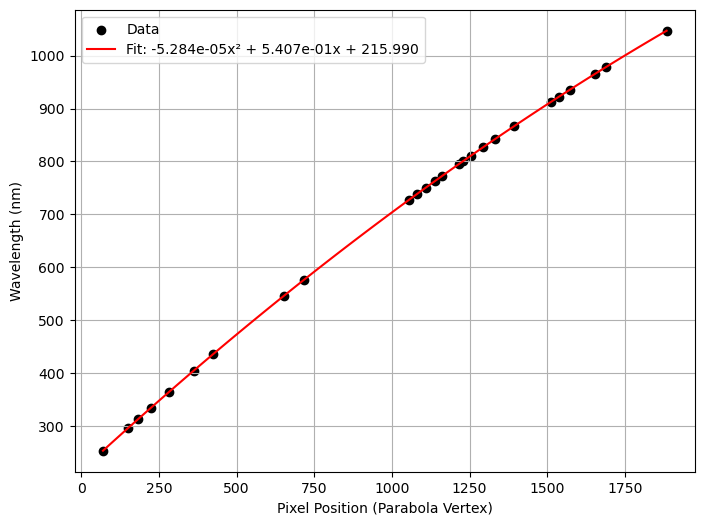

Best-fit parameters:
a = -5.284e-05 ± 8.001e-07
b = 5.407e-01 ± 1.493e-03
c = 215.990 ± 0.591


In [533]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the quadratic function
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

# Extract data
pp = linesDf['parabola_vertex'].values  # Pixel positions
ww = linesDf['wavelength'].values  # Wavelengths

multp = [984.68715344, 1005.04933128, 1024.40971885]
mp2 = [984.364812, 1007.91922]
mp3 = [1005.17108894, 1024.44537595]

ww[4] = 365.0158
# pp[4] = 283.535294#283.472345283.972866
pp[4] = 283.40771 # 283.972866
pp[0] = 70.212851

pp[2] = 182.980323
# pp[3] = 223.5

pp[7] = 652.060842
pp[11] = 1108.44088
pp[14] = 1214.69717
pp[15] = 1228.76038 #1227.8258896287377
# # pp[7] = 650.5614407098954
# pp[9] = 981.462665 #mp2[0] 981.954602 
# pp[10] = 1005.16 #mp2[1]
# pp[11] = 1024.7 #mp3[1]
# pp[12] = 1054.282710
# pp[14] = 1109.048332
# pp[15] = 1139.394344
# pp[16] = 1160.676470
# pp[17] = 1214.645900
# pp[18] = 1229.261429
# pp[19] = 1255.28973064
# # pp[21] = 1330.085255
# pp[22] = 1393.345245
# pp[23] = 1510.851856#1512.430755
# pp[-1] = 1883.887234

pp_unc = linesDf['parabola_vertex_unc'].values  # Pixel position uncertainties
names = linesDf['name']
pp_unc[np.isnan(pp_unc)] = 1.0

# pp = pp[np.where(np.abs(residuals)<1.)]
# ww = ww[np.where(np.abs(residuals)<1.)]
# pp_unc = pp_unc[np.where(np.abs(residuals)<1.)]

# Perform the fit
wpars = np.polyfit(pixel, wav, 2)
popt, pcov = curve_fit(quadratic, pp, ww, absolute_sigma=True, p0=wpars)
# popt, pcov = curve_fit(quadratic, pp, ww, sigma=pp_unc, absolute_sigma=True, p0=popt)

# Extract best-fit parameters and their uncertainties
a_fit, b_fit, c_fit = popt
a_err, b_err, c_err = np.sqrt(np.diag(pcov))  # Uncertainty from covariance matrix
 
# Generate fit curve
pp_fit = np.linspace(min(pp), max(pp), 100)
ww_fit = quadratic(pp_fit, *popt)

# Plot the data and the fit
plt.figure(figsize=(8, 6))
plt.scatter(pp, ww, label="Data", color="black", marker="o")
plt.plot(pp_fit, ww_fit, label=f"Fit: {a_fit:.3e}x² + {b_fit:.3e}x + {c_fit:.3f}", color="red")
plt.xlabel("Pixel Position (Parabola Vertex)")
plt.ylabel("Wavelength (nm)")
plt.legend()
plt.grid()
plt.show()

# Print fit results
print(f"Best-fit parameters:")
print(f"a = {a_fit:.3e} ± {a_err:.3e}")
print(f"b = {b_fit:.3e} ± {b_err:.3e}")
print(f"c = {c_fit:.3f} ± {c_err:.3f}")


In [534]:
pp[14]#1214.7549825077551

1214.69717

In [535]:
# linesDf['peak']

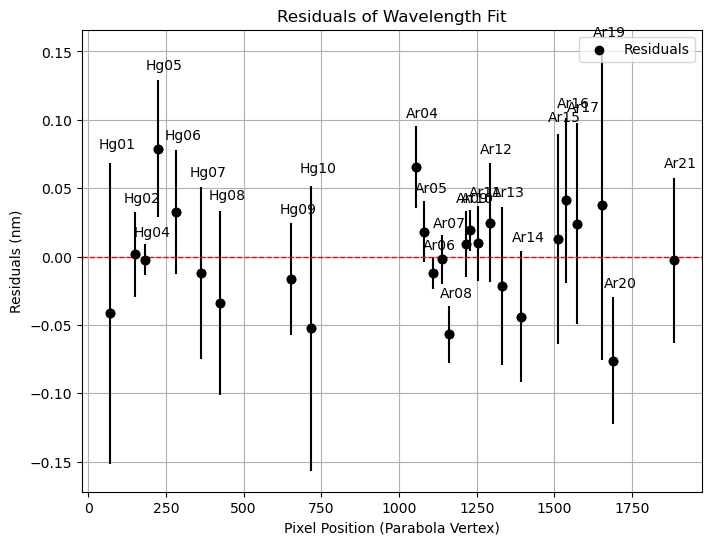

In [536]:
ww_fit = quadratic(pp, *popt)

# Compute residuals
residuals = ww - ww_fit

# Compute propagated uncertainty in wavelength
ww_unc = np.abs(2 * a_fit * pp + b_fit) * pp_unc  # Error propagation formula

# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(pp, residuals, color='black', marker='o', label="Residuals")
plt.errorbar(pp,residuals,yerr=ww_unc,fmt='o',color='k')
# Zero residual line
plt.axhline(0, color='red', linestyle='--', linewidth=1)  

# Annotate each point with its residual value
for i, txt in enumerate(names):
    plt.annotate(f"{txt}", (pp[i], residuals[i]+ww_unc[i]*1.05), textcoords="offset points", xytext=(5,5), ha='center')

# Labels and title
plt.xlabel("Pixel Position (Parabola Vertex)")
plt.ylabel("Residuals (nm)")
plt.title("Residuals of Wavelength Fit")
plt.legend()
plt.grid()
plt.savefig('residuals_wav_fit.png')

In [482]:
popt

array([-5.28373119e-05,  5.40693466e-01,  2.15990483e+02])

In [483]:
linesDf['residual'] = residuals

In [484]:
cols = ['exptime', 'wavelength', 'peak', 'peak_height', 'peak_fwhm', 'parabola_vertex', 'gauss_mean', 
        'centroid','peak_unc', 'parabola_vertex_unc', 'gauss_mean_unc', 'centroid_unc', 'chisqr','residual']
# linesDf[cols].corr()

In [485]:
# plt.scatter(linesDf['peak'], linesDf['peak_fwhm'])

In [380]:
# plt.scatter(residuals, res)

In [336]:
np.std(residuals)

0.05353367755015772

(array([1., 3., 3., 7., 7., 3., 0., 1., 0., 1.]),
 array([-0.10911915, -0.0821617 , -0.05520426, -0.02824681, -0.00128937,
         0.02566808,  0.05262552,  0.07958297,  0.10654042,  0.13349786,
         0.16045531]),
 <BarContainer object of 10 artists>)

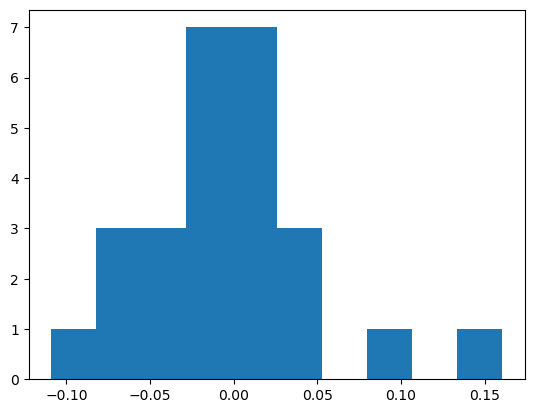

In [337]:
plt.hist(residuals)

In [326]:
wpars2 = np.polyfit(wav, pixel, 3)
def triple(x, a, b, c, d):
    return a * x**3 + b * x **2 + c *x +d
    
popt2, pcov2 = curve_fit(triple, ww, pp, p0=wpars2)
popt2

array([ 3.39147495e-07, -4.04438564e-05,  1.85411668e+00, -4.03875327e+02])

In [241]:
import pandas as pd
line_name = 'Ar01'
root = '/Users/esteves/Downloads/spectrometer_local/exptime'
timestamp = '20250311T153442'
df = pd.read_csv(f"./results/{timestamp}_{line_name}.csv")

In [223]:
# df

In [224]:
import numpy as np
def readtxt(file):
    data = np.loadtxt(file, skiprows=1)
    return data[:, 0], data[:, 1]  # Return wavelengths and counts

ix = 0#linesDf['name'].values == line_name
wav, c = readtxt(linesDf.fname.loc[ix])
pixel = np.arange(wav.size, dtype=int)

In [225]:
# linesDf['name'].values == line_name

In [226]:
int(np.where(linesDf['name'].values == line_name)[0])

TypeError: only length-1 arrays can be converted to Python scalars

NameError: name 'x' is not defined

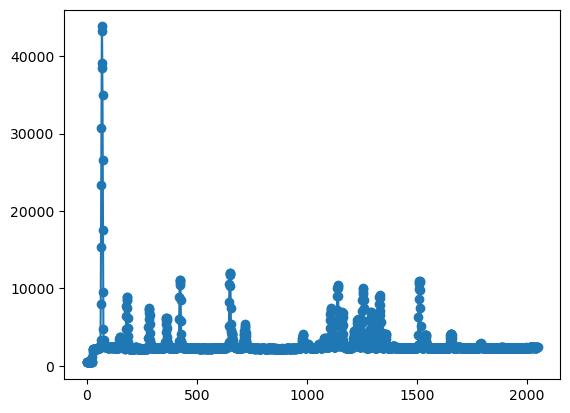

In [227]:
import matplotlib.pyplot as plt
window = 50
plt.plot(pixel, c)
plt.scatter(pixel, c)
plt.plot(x, y_smooth, 'k-', label='Sav-Gol Smoothed')
plt.xlim(linesDf.peak.loc[ix]-window/2,linesDf.peak.loc[ix]+window/2)
plt.ylim(0, linesDf['peak_height'].loc[ix]*1.06)

In [ ]:
def crop_line(wav, counts, line_wavelength, window):
    # Crop the data around the line
    mask = (wav >= line_wavelength - window) & (wav <= line_wavelength + window)
    return pixel[mask], counts[mask]

cropped_wav, cropped_counts = crop_line(pixel, c, linesDf.peak.loc[ix], window/2.)

In [ ]:
cropped_counts.size

In [ ]:
v

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

x = cropped_wav
y_noisy = cropped_counts

# Sav-Gol Filter
window_length = 11  # must be odd
polyorder = 2
y_smooth = savgol_filter(y_noisy, window_length, polyorder)

# Interpolate to a finer grid
x_fine = np.linspace(cropped_wav.min(), cropped_wav.max(), 4*cropped_wav.size)  # ~4x more points
f_interp = interp1d(x, y_smooth, kind='cubic')
y_fine = f_interp(x_fine)

# Plot
plt.figure(figsize=(8,5))
plt.plot(x, y_noisy, '-', label='Original Noisy Data', markersize=4)
plt.plot(x, y_smooth, 'k-', label='Sav-Gol Smoothed')
plt.plot(x_fine, y_fine, 'r--', label='Interpolated (cubic)')
plt.axvline(x[np.argmax(y_noisy)],color='k')
plt.axvline(x_fine[np.argmax(y_fine)],color='b')
v = linesDf.parabola_vertex.iloc[ix]
plt.axvline(v,color='r')
plt.legend()
plt.show()


In [ ]:
# help(np.blackman)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# # 1. Create a synthetic signal
# #    For demonstration, let's use two sine waves of different frequencies.
# #    We'll sample them at Fs=1000 Hz for 1 second.
signal = cropped_counts
Fs = signal.size/4
t = cropped_wav

# t = np.linspace(0, 1, Fs, endpoint=False)
# freq1, freq2 = 50, 120  # Hz
# signal = np.sin(2 * np.pi * freq1 * t) + 0.5 * np.sin(2 * np.pi * freq2 * t)

# 2. Compute the FFT of the raw signal (no window)
fft_raw = np.fft.fft(signal)
freqs = np.fft.fftfreq(len(signal), d=1/Fs)

# 3. Create and apply the Blackman window
#    np.blackman(N) generates an N-point Blackman window
window = np.blackman(len(signal))
signal_win = signal * window

# 4. Compute the FFT of the windowed signal
fft_win = np.fft.fft(signal_win)

# 5. Plot the raw signal and the windowed signal in time-domain
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
axs[0].plot(t, signal, label='Raw Signal', color='tab:blue')
axs[0].plot(t, signal_win, label='Windowed Signal', color='tab:red', alpha=0.7)
axs[0].axvline(t[np.argmax(signal)])
axs[0].axvline(t[np.argmax(signal_win)],color='r')
axs[0].set_title('Time Domain')
axs[0].legend()
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Amplitude')

# 6. Plot the magnitude of the FFT (frequency domain)
#    We'll limit to the positive frequencies for clarity
half = len(freqs)//2
axs[1].plot(freqs[:half], np.abs(fft_raw)[:half],
            label='Raw FFT', color='tab:blue')
axs[1].plot(freqs[:half], np.abs(fft_win)[:half],
            label='Blackman-Windowed FFT', color='tab:red', alpha=0.7)
axs[1].set_title('Frequency Domain (Magnitude)')
axs[1].legend()
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel('Magnitude')

plt.tight_layout()
plt.show()


In [ ]:
linesDf

In [504]:
import numpy as np
import lmfit

def composite_residual(params, x, w, sigma_x, sigma_w):
    """
    Compute residuals for both forward (pixel -> wavelength) and inverse (wavelength -> pixel) fits.
    
    Model: w = a + b*x + c*x^2
    Inverse: x = (-b + sqrt(b^2 - 4*c*(a-w)))/(2*c)
    
    Parameters:
        params   : lmfit.Parameters with 'a', 'b', 'c'
        x        : array of pixel values (with uncertainties sigma_x)
        w        : array of wavelength values (with uncertainties sigma_w)
        sigma_x  : array of uncertainties in x (pixel)
        sigma_w  : array of uncertainties in w (wavelength)
    
    Returns:
        A concatenated array of residuals.
    """
    a = params['a']
    b = params['b']
    c = params['c']
    
    # Forward model: predicted wavelengths from pixels
    w_pred = a + b * x + c * x**2
    resid_forward = (w - w_pred) / sigma_w

    # Compute the discriminant for the quadratic inverse.
    # Assumed always positive (per your case)
    disc = b**2 - 4 * c * (a - w)
    # Inverse model: predicted pixels from wavelengths using the quadratic formula.
    # We choose the positive square-root solution.
    x_pred = (-b + np.sqrt(disc)) / (2 * c)
    resid_inverse = (x - x_pred) / sigma_x

    # Combine the residuals (you may also consider weighting these parts differently)
    return np.concatenate([resid_forward, resid_inverse])

# Example usage:
# Suppose you have arrays: x (pixels), w (wavelengths),
# sigma_x (error in pixel), sigma_w (error in wavelength)
# These must be defined from your calibration data.
sigma_x = pp_unc
sigma_w = ww_unc

x = pp
w = ww

# Set up initial guess parameters
params = lmfit.Parameters()
params.add('c', value=popt[0])
params.add('b', value=popt[1])
params.add('a', value=popt[2])

# Now perform the minimization
result = lmfit.minimize(composite_residual, params, args=(x, w, sigma_x, sigma_w))

# Extract the fitted parameters:
a_fit = result.params['a'].value
b_fit = result.params['b'].value
c_fit = result.params['c'].value

print(f"Fitted parameters: a = {a_fit:.6f}, b = {b_fit:.6f}, c = {c_fit:.6f}")


Fitted parameters: a = 215.988903, b = 0.540709, c = -0.000053


In [506]:
a_fit, b_fit, c_fit

(215.98890252978637, 0.5407093452860331, -5.2850423335544134e-05)

In [501]:
w = 70
disc = b_fit**2 - 4 * c_fit * (a_fit - w)

In [502]:
np.sqrt(disc)

245.9220879545779

In [517]:
from scipy import odr

# Define a polynomial function for y = a + b*x + c*x^2
def poly_model(beta, x):
    # beta[0] = a, beta[1] = b, beta[2] = c
    return beta[0] + beta[1]*x + beta[2]*x**2

def inv_poly_model(beta, w):
    a, b, c = beta
    # Compute the discriminant for the quadratic inverse.
    # Assumed always positive (per your case)
    disc = b**2 - 4 * c * (a - w)
    # Inverse model: predicted pixels from wavelengths using the quadratic formula.
    # We choose the positive square-root solution.
    x_pred = (-b + np.sqrt(disc)) / (2 * c)
    return x_pred

sigma_x = pp_unc
sigma_w = ww_unc

# Create a Model for ODR
model = odr.Model(poly_model)

# Create a RealData object, passing x, y, and their errors
data = odr.RealData(x, w, sx=sigma_x)

# Set up ODR with the model, data, and initial guess
myodr = odr.ODR(data, model, beta0=popt)

# Run the regression
out = myodr.run()

# Extract best-fit parameters
a_fit, b_fit, c_fit = out.beta
print("Fitted parameters: a=%.6f, b=%.6f, c=%.6f" % (a_fit, b_fit, c_fit))

# 2D parameter covariance matrix, etc.
print("Parameter standard errors:", out.sd_beta)
print("Covariance matrix:\n", out.cov_beta)

Fitted parameters: a=215.990586, b=0.540693, c=-0.000053
Parameter standard errors: [2.29150516e-02 5.79275672e-05 3.10379207e-08]
Covariance matrix:
 [[ 3.50291797e-01 -7.42571801e-04  3.35385536e-07]
 [-7.42571801e-04  2.23850913e-06 -1.16270863e-09]
 [ 3.35385536e-07 -1.16270863e-09  6.42648543e-13]]


In [518]:
ww_fit = poly_model(out.beta, x)

# Compute residuals
residuals = ww - ww_fit


In [519]:
np.std(residuals)

0.03648270314055003

In [520]:
xx_fit = inv_poly_model(out.beta, ww)
np.std(x-xx_fit)

0.08584139038042755

<ErrorbarContainer object of 3 artists>

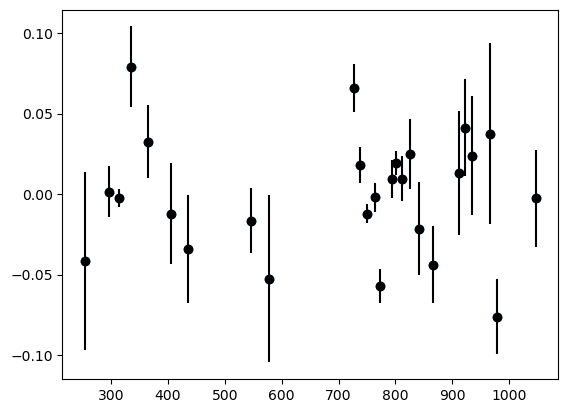

In [526]:
plt.scatter(ww, residuals)
plt.errorbar(ww, residuals, fmt='o', yerr=sigma_w/2.,color='k')

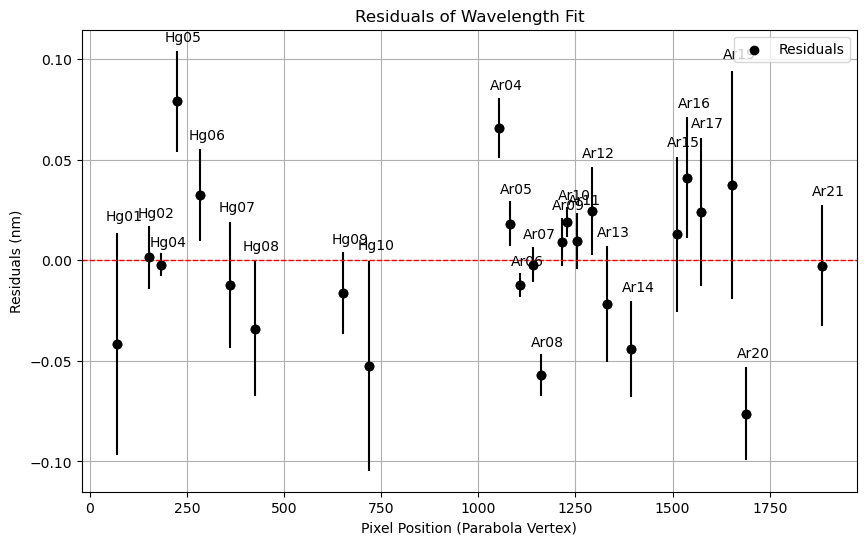

In [541]:
# Compute residuals
residuals = ww - ww_fit

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(pp, residuals, color='black', marker='o', label="Residuals")
plt.errorbar(pp,residuals,yerr=ww_unc/2.,fmt='o',color='k')
# Zero residual line
plt.axhline(0, color='red', linestyle='--', linewidth=1)  

# Annotate each point with its residual value
for i, txt in enumerate(names):
    plt.annotate(f"{txt}", (pp[i], residuals[i]+ww_unc[i]*1.05/2.), textcoords="offset points", xytext=(5,5), ha='center')

# Labels and title
plt.xlabel("Pixel Position (Parabola Vertex)")
plt.ylabel("Residuals (nm)")
plt.title("Residuals of Wavelength Fit")
plt.legend()
plt.grid()
plt.savefig('residuals_wav_fit.png', dpi=120)

In [19]:
import numpy as np
import pandas as pd
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def quadratic(x, a, b, c):
    return a*x**2 + b*x + c

def quadratic_inv(w, a, b, c):
    disc = b**2 - 4 * c * (a - w)
    x_pred = (-b + np.sqrt(disc)) / (2 * c)
    return x_pred

class WaveLengthCalibrationModel:
    def __init__(self, lines, outdir='.'):
        self.lines = lines
        self.fname_loc = outdir + "/results/{name}.csv"
        self.params = dict()
        self.covparams = dict()
        self.residuals = dict()
        self.values = dict()
        self.errors = dict()
        self.prediction = dict()
        self.rmse = dict()
        self.names = list(self.lines.keys())

        # Put your wavelength array
        self.wav = np.array(list(self.lines.values()))
    
    def load_lines(self):
        dfs = []
        for name, peak in self.lines.items():
            fname = self.fname_loc.format(name=name)
            if os.path.isfile(fname):
                line = pd.read_csv(fname, index_col=0, header=[0, 1])
                # This returns a Series with multi-level index = columns
                row_series = line.iloc[-1]            
                # Convert Series -> DataFrame (1 row) with multi-level columns
                row_df = row_series.to_frame().T
                # Rename the row index so it becomes e.g. "Hg_line" etc.
                row_df.index = [name]
                dfs.append(row_df)
            else:
                continue
        self.df = pd.concat(dfs)
        self.names = [l for l in list(self.df.index) if l in self.names]
        pass
        
    def fit(self, method='gaussianModel'):
        # cal.df.loc[list(cal.lines.keys()), ('peak','center')].values
        centers = self.df.loc[self.names,(method,'center')].values.astype(float)
        errors = self.df.loc[self.names,(method,'error')].values.astype(float)
        wav = np.array([self.lines[l] for l in list(self.df.index) if l in self.names])
        
        p0 = np.polyfit(centers, wav, 2)
        # Fit a quadratic (pixel -> wavelength)
        popt, pcov = curve_fit(
            quadratic, centers, wav, absolute_sigma=True,
            p0=p0
        )
        self.params[method] = popt
        self.covparams[method] = np.sqrt(np.diag(pcov))
        
        # residual = measured wavelength - fitted wavelength
        fitted_wav = quadratic(centers, *popt)
        self.residuals[method] = wav - fitted_wav
        
        # We'll store the *pixel positions* in self.values
        self.values[method] = centers
        self.errors[method] = errors
        self.prediction[method] = fitted_wav
        
        # Compute standard deviation of residuals (RMSE)
        self.rmse[method] = np.sqrt(np.mean(self.residuals[method]**2))
    
    def plot_residuals(self, method='gaussianModel', ax=None, color='k'):
        # Quick reference
        residuals = self.residuals[method]
        pp = self.values[method]
        pp_unc = self.errors[method]
        pp_unc[np.isnan(pp_unc)] = 1.0
        
        names = list(self.df.index.values)

        # Unpack best-fit params
        a_fit, b_fit, c_fit = self.params[method]
        
        # Propagation of error from pixel->wavelength
        # derivative of f(x) = 2a*x + b, so:
        #    dW = |(2a * x + b)| * dx
        # I'm dividing by 2. not sure if that's your intention;
        # adjust if needed
        ww_unc = np.abs(2*a_fit*pp + b_fit) * pp_unc
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))

        # Scatter + errorbars
        ax.scatter(pp, residuals, color=color, marker='o', label="Residuals")
        ax.errorbar(pp, residuals, yerr=ww_unc, fmt='o', color=color)
        
        # Zero residual line
        ax.axhline(0, color='red', linestyle='--', linewidth=1)

        # Annotate each point
        for i, txt in enumerate(names):
            ax.annotate(
                txt,
                (pp[i], residuals[i] + ww_unc[i] * 1.05),
                textcoords="offset points",
                xytext=(5,5),
                ha='center'
            )

        ax.set_xlabel("Pixel Position")
        ax.set_ylabel("Residuals (nm)")
        ax.set_title(f"Residuals of Wavelength Fit ({method})")
        ax.legend()
        ax.grid(True)

    def fit_all_methods(self):
        methods = [
            'peak', 'parabola_vertex', 'moment_center', 'savgolFilter',
            'lorentzianModel','skewedGaussianModel','gaussianModel',
            'voigtModel','splitLorentzianModel'
        ]
        for method in methods:
            print(method)
            self.fit(method)

    def print_all_rmse(self):
        """
        Prints the RMSE for each method in self.rmse.
        """
        print("=== RMSE for each method ===")
        for method, rmse_val in self.rmse.items():
            print(f"{method:25s} -> {rmse_val:.4f} nm")
    
    def plot_all_rmse(self):
        """
        Plots a simple bar chart of the RMSE for each method.
        """
        methods = list(self.rmse.keys())
        rmse_values = [self.rmse[m] for m in methods]

        fig, ax = plt.subplots(figsize=(8, 6))
        ax.bar(methods, rmse_values)
        
        # Make the x-axis labels readable
        ax.set_xticks(range(len(methods)))
        ax.set_xticklabels(methods, rotation=45, ha='right')
        
        ax.set_ylabel("RMSE (nm)")
        ax.set_title("Comparison of RMSE for Each Method")
        ax.grid(True)
        plt.tight_layout()
        plt.show()

In [111]:
hg2_lines = {
    # Mercury (Hg) lines
    "Hg01": 253.65200,
    # "Hg02": 296.72840,
    # "Hg03": 302.15060,
    "Hg04": 313.155,  # blended line
    "Hg05": 334.14820,
    "Hg06": 365.0152,  # blended line
    "Hg07": 404.65650,
    "Hg08": 435.83430,
    # "Hg09": 546.0750,
    "Hg10": 576.95980,

    # Argon (Ar) lines
    # "Ar01":  696.54310,
    # "Ar02":  706.72180,
    # "Ar03":  714.70420,
    "Ar04":  727.29360,
    "Ar05":  738.39800,
    "Ar06":  750.3869,  # blended line
    "Ar07":  763.51100,
    "Ar08":  772.376,   # blended line
    "Ar09":  794.81760,
    "Ar10":  800.616,   # blended line
    "Ar11":  811.531,   # blended line
    "Ar12":  826.45180,
    "Ar13":  842.465,   # blended line
    "Ar14":  852.14400,
    "Ar15":  866.79400,
    "Ar16":  912.29670,
    "Ar17":  922.44990,
    "Ar18":  935.42200,
    "Ar19":  965.77860,
    "Ar20":  978.45100,
    "Ar21":  1047.0050,
    # "Ar22":  1067.3570,
    # "Ar23":  1107.8870,
}

In [189]:
# from pandora.calibration.hg2_lamp import hg2_lines as lines
cal = WaveLengthCalibrationModel(hg2_lines, outdir="..")
cal.load_lines()

# Hg02: (151.54317434908376, 0.08638529564389656)
# Hg03: (162.00828078425658, 0.35104660795006176)

cal.df.loc['Hg04',('gaussianModel','center')] = 183.837749249316
# cal.df.loc['Hg06',('gaussianModel','center')] = 284.1593127671484
cal.df.loc['Hg06',('gaussianModel','center')] = 284.2017250845611
cal.df.loc['Hg06',('gaussianModel','error')] = 0.1806918041297908

cal.df.loc['Hg07',('gaussianModel','center')] = 362.3070034915113
# cal.df.loc['Hg07',('gaussianModel','center')] = 362.25015098200305
# cal.df.loc['Hg09',('gaussianModel','center')] = 651.7175601259991
cal.df.loc['Hg10',('gaussianModel','error')] = 0.30

cal.df.loc['Ar06',('gaussianModel','center')] = 1108.4720517028056
cal.df.loc['Ar08',('gaussianModel','center')] = 1160.6927720816698
cal.df.loc['Ar09',('gaussianModel','center')] = 1214.7651150583583
cal.df.loc['Ar09',('gaussianModel','error')] = 0.10227321526524288

cal.df.loc['Ar10',('gaussianModel','center')] = 1228.8461553333932
cal.df.loc['Ar10',('gaussianModel','error')]  = 0.06888983435958825

cal.df.loc['Ar11',('gaussianModel','center')] = 1255.5249503119471
cal.df.loc['Ar13',('gaussianModel','center')] = 1331.9978349101002
cal.df.loc['Ar13',('gaussianModel','error')]  = 0.0960172562122789
#############################################
# cal.df.loc['Hg06',('savgolFilter','center')] = 284.1593127671484
# cal.df.loc['Hg06',('savgolFilter','error')] = 0.12749143015974462

# cal.df.loc['Hg07',('savgolFilter','center')] =362.25015098200305
# # cal.df.loc['Hg09',('savgolFilter','center')] = 652.0709921021108

# cal.df.loc['Ar06',('savgolFilter','center')] = 1108.289793959364
# cal.df.loc['Ar08',('savgolFilter','center')] = 1160.6927720816698
# cal.df.loc['Ar09',('savgolFilter','center')] = 1214.7651150583583
# cal.df.loc['Ar09',('savgolFilter','error')] = 0.10227321526524288

# cal.df.loc['Ar10',('savgolFilter','center')] = 1228.8461553333932
# cal.df.loc['Ar10',('savgolFilter','error')]  = 0.06888983435958825

# cal.df.loc['Ar11',('savgolFilter','center')] = 1255.5249503119471
# cal.df.loc['Ar13',('savgolFilter','center')] = 1331.7001662763253
# cal.df.loc['Ar13',('savgolFilter','error')]  = 0.0960172562122789


cal.fit_all_methods()

peak
parabola_vertex
moment_center
savgolFilter
lorentzianModel
skewedGaussianModel
gaussianModel
voigtModel
splitLorentzianModel


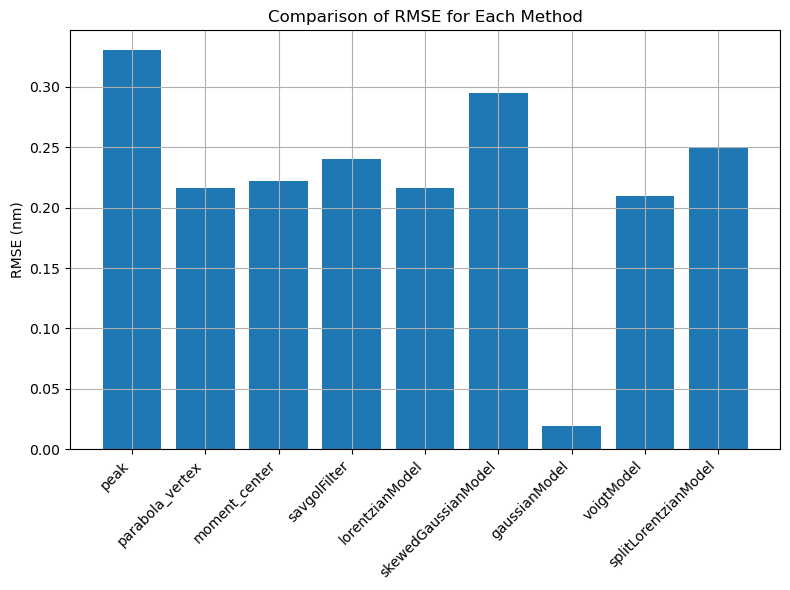

In [190]:
cal.plot_all_rmse()

In [191]:
len(hg2_lines.keys())

25

In [192]:
cal.print_all_rmse()

=== RMSE for each method ===
peak                      -> 0.3303 nm
parabola_vertex           -> 0.2167 nm
moment_center             -> 0.2221 nm
savgolFilter              -> 0.2401 nm
lorentzianModel           -> 0.2162 nm
skewedGaussianModel       -> 0.2946 nm
gaussianModel             -> 0.0192 nm
voigtModel                -> 0.2093 nm
splitLorentzianModel      -> 0.2505 nm


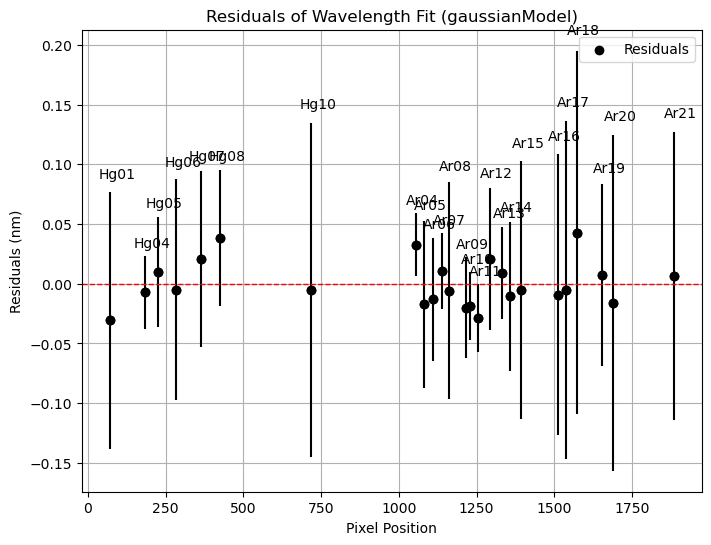

In [193]:
cal.plot_residuals(method='gaussianModel')

In [194]:
ix = np.where(np.array(cal.names)=='Hg04')[0]

In [195]:
cal.residuals['peak'][ix]

array([0.27523798])

In [196]:
cal.residuals['savgolFilter'][ix]

array([0.40948601])

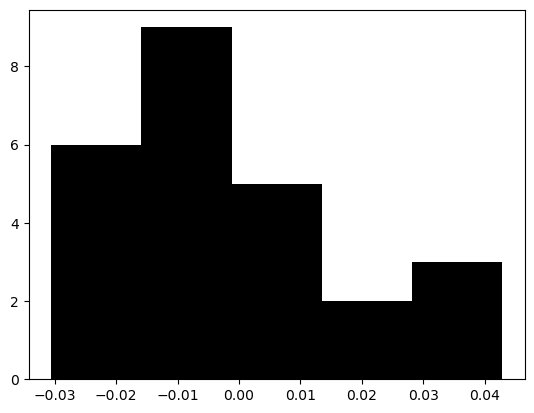

In [202]:
_ = plt.hist(cal.residuals['gaussianModel'], bins=int(len(cal.residuals['gaussianModel'])/5), color='k')

In [203]:
np.max(np.abs(cal.residuals['gaussianModel']))

0.04282400051965851

In [129]:
cal.df.loc['Hg06']

line_info             timestamp      20250311T153442
                      name                      Hg06
                      wavelength            365.4842
                      exptime                     37
                      peak_height       59096.193305
                      fwhm                  7.639312
parabola_vertex       center              284.420618
                      error                 0.126429
                      rsquared                   NaN
moment_center         center              284.722876
                      error                 0.586506
                      rsquared                   NaN
peak                  center                     284
                      error                      1.0
                      rsquared                   NaN
savgolFilter          center              284.159313
                      error                 0.127491
                      rsquared                   NaN
lorentzianModel       center              284.

In [740]:
gm = np.poly1d(cal.params['gaussianModel'])
csp = np.poly1d(np.array([-5.45224991e-05,  5.44322051e-01,  2.14279999e+02]))

In [741]:
cmcoefs = np.array([-5.45224991e-05,  5.44322051e-01,  2.14279999e+02])

np.abs((cal.params['gaussianModel']- cmcoefs)/cmcoefs)

array([0.02485824, 0.00503981, 0.00525355])

In [742]:
cal.params['gaussianModel'][-1]

215.40572933604375

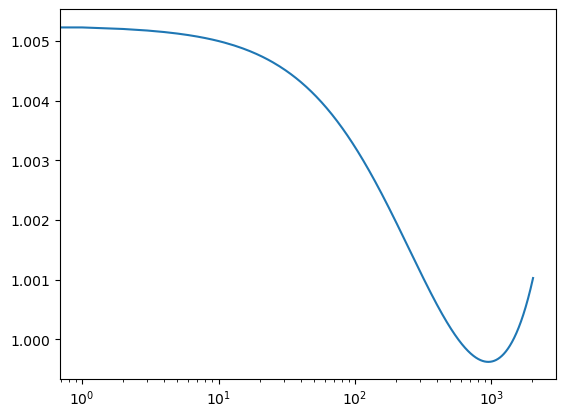

In [743]:
p = np.arange(2024)
plt.plot(p, gm(p)/csp(p))
plt.xscale('log')